In [ ]:
#| hide


# textplumber

> Pipeline components for Sci-kit learn to extract relevant features from text data, including tokens, parts of speech, lexicon scores, document-level statistics and embeddings.

This package is currently for testing only.

## Usage

### Installation

Install latest from the GitHub [repository][repo]:

```sh
$ pip install git+https://github.com/polsci/textplumber.git
```

or from [pypi][pypi]

```sh
$ pip install textplumber
```

[repo]: https://github.com/polsci/textplumber
[docs]: https://geoffford.nz/textplumber/
[pypi]: https://pypi.org/project/textplumber/


### Documentation

Documentation can be found hosted on this GitHub [repository][repo]'s [pages][docs]. Additionally you can find package manager specific guidelines on [pypi][pypi].

[repo]: https://github.com/polsci/textplumber
[docs]: https://geoffford.nz/textplumber/
[pypi]: https://pypi.org/project/textplumber/


## How to use

THe intention of textplumber is to make it easy to extract features from text data for use in Sci-kit learn pipelines. It allows you to combine different kinds of features extracted from text. Here's an example ...

In [ ]:
#| hide
from datasets import load_dataset
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2
from sklearn.pipeline import FeatureUnion

from textplumber.core import *
from textplumber.clean import *
from textplumber.preprocess import *
from textplumber.tokens import *
from textplumber.pos import *
from textplumber.embeddings import *
from textplumber.report import *
from textplumber.store import *
from textplumber.lexicons import *
from textplumber.textstats import *

/home/geoff/miniconda3/envs/textplumber/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First, let's load some data ...

In [ ]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd

cats = ['talk.politics.misc', 'talk.religion.misc']
dataset = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=cats)

X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, test_size = 0.2, random_state=42)

target_names = dataset.target_names
target_classes = list(range(len(target_names)))

Next, define an SQLite database to store features so we can avoid recomputing them every time we run the pipeline. A feature store is required for most of the components in this package.

In [ ]:
feature_store = TextFeatureStore('test_feature_store.sqlite')

In [ ]:
#| hide
feature_store.empty()

Now, setup a pipeline ...

In [ ]:
pipeline = Pipeline([
    ('cleaner', TextCleaner(strip_whitespace=True)),
    ('preprocessor', SpacyPreprocessor(feature_store=feature_store)),
    ('tokens', TokensVectorizer(feature_store=feature_store, lowercase=True, max_features=1000, remove_punctuation = True, remove_numbers=True, min_token_length=2)),
    ('classifier', MultinomialNB()),
], verbose=True)

display(pipeline)


Pipeline(steps=[('cleaner', TextCleaner(strip_whitespace=True)),
                ('preprocessor',
                 SpacyPreprocessor(feature_store=<textplumber.store.TextFeatureStore object>)),
                ('tokens',
                 TokensVectorizer(feature_store=<textplumber.store.TextFeatureStore object>,
                                  lowercase=True, max_features=1000,
                                  min_token_length=2, remove_numbers=True,
                                  remove_punctuation=True)),
                ('classifier', MultinomialNB())],
         verbose=True)

In the example pipeline, the texts are cleaned with `TextCleaner`, then preprocessed using `SpacyPreprocessor`, and then vectors based on token counts are extracted using `TokensVectorizer`.

Now, let's train a model ...

In [ ]:
pipeline.fit(X_train, y_train)

[Pipeline] ........... (step 1 of 4) Processing cleaner, total=   0.0s
[Pipeline] ...... (step 2 of 4) Processing preprocessor, total=  15.4s
[Pipeline] ............ (step 3 of 4) Processing tokens, total=   0.1s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   0.0s


Pipeline(steps=[('cleaner', TextCleaner(strip_whitespace=True)),
                ('preprocessor',
                 SpacyPreprocessor(feature_store=<textplumber.store.TextFeatureStore object>)),
                ('tokens',
                 TokensVectorizer(feature_store=<textplumber.store.TextFeatureStore object>,
                                  lowercase=True, max_features=1000,
                                  min_token_length=2, remove_numbers=True,
                                  remove_punctuation=True)),
                ('classifier', MultinomialNB())],
         verbose=True)

We can evaluate the model on the test set. To output a nice confusion matrix use `plot_confusion_matrix`.

                    precision    recall  f1-score   support

talk.politics.misc      0.816     0.772     0.793        92
talk.religion.misc      0.744     0.792     0.767        77

          accuracy                          0.781       169
         macro avg      0.780     0.782     0.780       169
      weighted avg      0.783     0.781     0.781       169



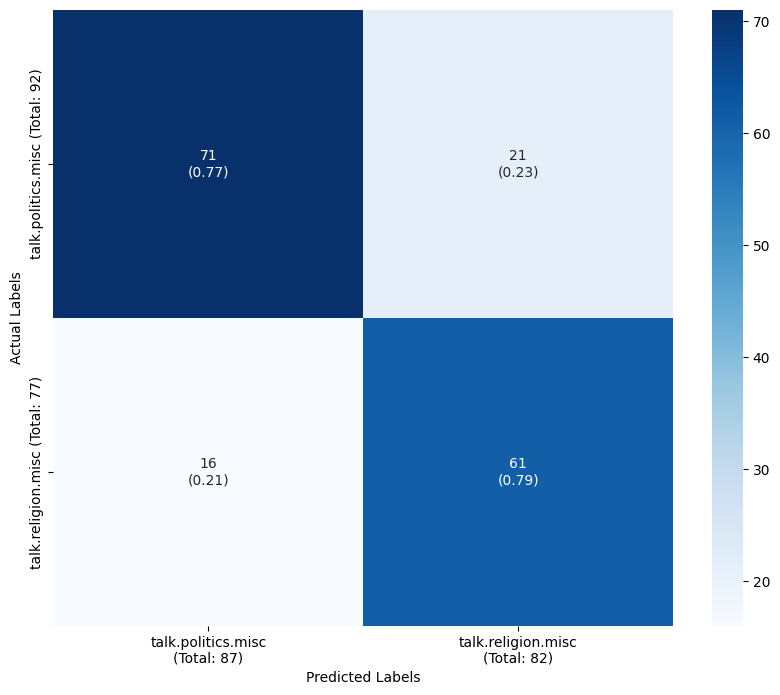

In [ ]:
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred, labels = target_classes, target_names = target_names, digits=3))
plot_confusion_matrix(y_test, y_pred, target_classes, target_names)

Let's create a more complex pipeline with different kinds of features, but first we need our lexicon.

In [ ]:
empath_lexicons = get_empath_lexicons()

Now, let's build a pipeline that combines tf-idf weighted token features and embeddings. This applies feature selection using standard scikit-learn components.

In [ ]:
pipeline = Pipeline([
    ('cleaner', TextCleaner(strip_whitespace=True)),
    ('preprocessor', SpacyPreprocessor(feature_store=feature_store)),
    ('features', FeatureUnion([

        ('tokens', Pipeline([
            ('tokens_vectors',  TokensVectorizer(feature_store=feature_store, vectorizer_type = 'tfidf', lowercase=True, max_features=5000, remove_punctuation = True, remove_numbers=True, min_token_length=2)),
            ('selector', SelectKBest(score_func=chi2, k=100)),
            ], verbose=True)
        ),
        ('embeddings', Model2VecEmbedder(feature_store=feature_store)),
    ], verbose=True)),
    ('classifier', LogisticRegression(max_iter=1000, random_state=4)),
], verbose=True)

display(pipeline)

Pipeline(steps=[('cleaner', TextCleaner(strip_whitespace=True)),
                ('preprocessor',
                 SpacyPreprocessor(feature_store=<textplumber.store.TextFeatureStore object>)),
                ('features',
                 FeatureUnion(transformer_list=[('tokens',
                                                 Pipeline(steps=[('tokens_vectors',
                                                                  TokensVectorizer(feature_store=<textplumber.store.TextFeatureStore object>,
                                                                                   l...
                                                                                   remove_numbers=True,
                                                                                   remove_punctuation=True,
                                                                                   vectorizer_type='tfidf')),
                                                                 ('selector',
                                                                  SelectKBest(k=100,
                                                                              score_func=<function chi2>))],
                                                          verbose=True)),
                                                ('embeddings',
                                                 Model2VecEmbedder(feature_store=<textplumber.store.TextFeatureStore object>))],
                              verbose=True)),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=4))],
         verbose=True)

In [ ]:
pipeline.fit(X_train, y_train)

[Pipeline] ........... (step 1 of 4) Processing cleaner, total=   0.0s
[Pipeline] ...... (step 2 of 4) Processing preprocessor, total=   0.0s
[Pipeline] .... (step 1 of 2) Processing tokens_vectors, total=   0.1s
[Pipeline] .......... (step 2 of 2) Processing selector, total=   0.0s
[FeatureUnion] ........ (step 1 of 2) Processing tokens, total=   0.1s
[FeatureUnion] .... (step 2 of 2) Processing embeddings, total=   5.8s
[Pipeline] .......... (step 3 of 4) Processing features, total=   5.9s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   0.0s


Pipeline(steps=[('cleaner', TextCleaner(strip_whitespace=True)),
                ('preprocessor',
                 SpacyPreprocessor(feature_store=<textplumber.store.TextFeatureStore object>)),
                ('features',
                 FeatureUnion(transformer_list=[('tokens',
                                                 Pipeline(steps=[('tokens_vectors',
                                                                  TokensVectorizer(feature_store=<textplumber.store.TextFeatureStore object>,
                                                                                   l...
                                                                                   remove_numbers=True,
                                                                                   remove_punctuation=True,
                                                                                   vectorizer_type='tfidf')),
                                                                 ('selector',
                                                                  SelectKBest(k=100,
                                                                              score_func=<function chi2>))],
                                                          verbose=True)),
                                                ('embeddings',
                                                 Model2VecEmbedder(feature_store=<textplumber.store.TextFeatureStore object>))],
                              verbose=True)),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=4))],
         verbose=True)

                    precision    recall  f1-score   support

talk.politics.misc      0.830     0.902     0.865        92
talk.religion.misc      0.870     0.779     0.822        77

          accuracy                          0.846       169
         macro avg      0.850     0.841     0.843       169
      weighted avg      0.848     0.846     0.845       169



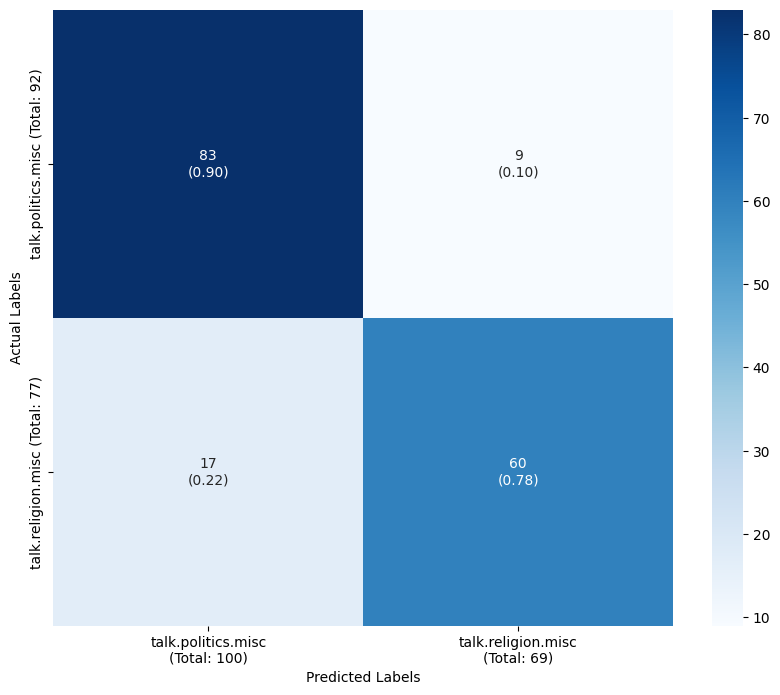

In [ ]:
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred, labels = target_classes, target_names = target_names, digits=3))
plot_confusion_matrix(y_test, y_pred, target_classes, target_names)

In [ ]:
        # ('lexicon', Pipeline([
        #     ('lexicon_vectors', LexiconCountVectorizer(feature_store=feature_store, lexicons=empath_lexicons)),
        #     ('scaler', StandardScaler(with_mean=False))
        #     ], verbose=True)
        # ),
        # ('pos', Pipeline([
        #     ('pos_vectors',  POSVectorizer(feature_store=feature_store)),
        #     ('selector', StandardScaler(with_mean=False)),
        #     ], verbose=True)
        # ),
        # ('textstats', Pipeline([
        #     ('textstats_vectors', TextstatsTransformer(feature_store=feature_store)),
        #     ('scaler', StandardScaler(with_mean=False))
        #     ], verbose=True)
        # ),


In [ ]:
# #| hide
os.remove('test_feature_store.sqlite')

## Developer Guide

If you are new to using `nbdev` here are some useful pointers to get you started.

### Install textplumber in Development mode

```sh
# make sure textplumber package is installed in development mode
$ pip install -e .

# make changes under nbs/ directory
# ...

# compile to have changes apply to textplumber
$ nbdev_prepare
```